# Lab 7: Convolutional Neural Networks
In this notebook we will learn how to train a simple Convolutional Neural Network (CNN) for image classification using PyTorch.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

### Load dataset

In [4]:
# torchvision has some datasets already included, so we will load MNIST through torchvision
# first we need to define the transformations
# change to tensor and scale the image into [0., 1.0] range
data_aug = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)

100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


## How to use datasets that are not available on torchvision?

Download dataset and upload them to drive or to the notebook. [Download MNIST here!](https://git-disl.github.io/GTDLBench/datasets/mnist_datasets/)

For MNIST we will use the python.mnist package to read its files.

In [5]:
!pip install python-mnist

**Option 1**: Upload dataset to Google Drive

First, we need to mount the drive on the colab notebook by running the following code and allowing access.

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then, we need to load the data from the correct path.

In [45]:
import os
from google.colab import drive
from mnist import MNIST

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the 'data' directory on your Drive
data_path = '/content/drive/My Drive/data'  # Replace with your actual path

# Check if the 'data' directory exists on your Drive
if not os.path.exists(data_path):
    print(f"Error: The 'data' directory does not exist at {data_path}. Please download and extract the MNIST dataset into this directory.")
else:
    # Load data using MNIST package
    mndata = MNIST(data_path)

    # Load images and labels from path
    train_images, train_labels = mndata.load_training()
    test_images, test_labels = mndata.load_testing()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Option 2**: Upload dataset directly to Colab

In [46]:
from mnist import MNIST
data_path = '/content/drive/My Drive/data'  # Replace with your actual path

# Load data using MNIST package - change the path to the folder where you saved the dataset on drive
mndata = MNIST(data_path)

# Load images and labels from path
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

## Defining Custom Dataset class

Now that we have the images and labels, we can define a custom dataset class that can be used to retrieve and preprocess the data. (Click here for more information on Datasets and Dataloaders.)[https://pytorch.org/tutorials/beginner/basics/data_tutorial.html]

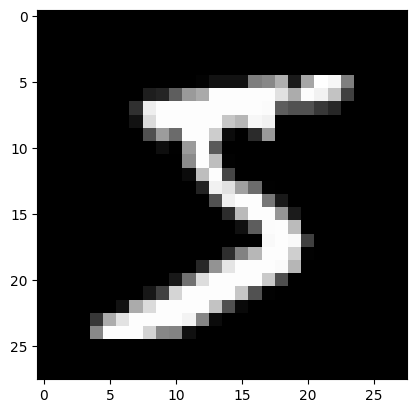

In [47]:
class MNISTCustomDataset(Dataset):
  def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
      image = self.images[idx]
      image = np.array(image, dtype=np.uint8).reshape((28, 28))

      # Transform array into grayscale image
      image = Image.fromarray(image, mode='L')

      # Apply transformations to the image
      if self.transform:
        image = self.transform(image)

      label = int(self.labels[idx])
      return (image, label)

# Define transformations
data_aug = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])

# Define custom dataset for the training and validation data
training_data = MNISTCustomDataset(train_images, train_labels, transform=data_aug)
validation_data = MNISTCustomDataset(test_images, test_labels, transform=data_aug)

# Show one image
plt.imshow(training_data[0][0][0,:,:], cmap='gray')

Divide validation set into validation (80%) and test (20%) subsets.

In [48]:
indices = list(range(len(validation_data)))
np.random.shuffle(indices, )

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(f'Training size: {len(training_data)}\nValidation size: {len(val_idx)} \nTest size: {len(test_idx)}')

Training size: 60000
Validation size: 8000 
Test size: 2000


Define data loaders to automatically obtain batches of images to train the model



In [49]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

batch_size = 64 # how many images are processed at a time
num_workers = 2 # how many processes are used to load the data

# Define data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


## Defining the model

Create a CNN with the following structure:

1. convolutional layer with 32 output channels and 3x3 kernel
2. ReLU activation layer
3. convolutional layer with 32 input/output channels and 3x3 kernel
4. ReLU activation layer
5. max pooling layer with a kernel size of 2
6. dropout with 0.25 probability
7. flattening layer (to convert the 3D tensors into 1D tensors to be fed to the dense layers)
8. dense/linear layer with 128 output channels
9. ReLU activation layer
10. dropout layer with 0.5 probability
11. dense/linear layer with 10 output channels (10 classes of MNIST)

You can use PyTorch's layers: https://pytorch.org/docs/stable/nn.html (Conv2d, ReLU, Linear, MaxPool2d, Dropout, Flatten)




In [51]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )

        dummy_input = torch.zeros(1, 1, 28, 28)
        conv_output_size = self.conv_layers(dummy_input).view(1, -1).size(1)

        ''' Let’s break that down:

        torch.zeros(1, 1, 28, 28)
        Creates a fake image tensor of shape [batch_size=1, channels=1, height=28, width=28]. This mimics a MNIST image.

        self.conv_layers(dummy_input)
        Passes the dummy image through the convolutional layers to see what the output shape would be after conv, ReLU, pooling, dropout.

        .view(1, -1)
        Flattens the output to a shape like [1, N], where N is the number of features (exact number depends on how the spatial dimensions changed through conv/pool layers).

        .size(1)
        Extracts N — the number of input features needed for the first linear layer. '''


        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = ConvolutionalNeuralNetwork().to(device) # put model in device (GPU or CPU)
print(model)

ConvolutionalNeuralNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Interpret the implemented architecture and try to answer the following questions:

a) What is the shape (width, height and # of channels) of the output tensor after the first convolution layer?

b) And after the first 3 layers (convolution+convolution+pooling)?

c) How many parameters (weights) does the model have? Contrary to Keras, PyTorch does not have an official method for counting the number of parameters of a model, but you can use [torchsummary](https://github.com/sksq96/torchsummary).

## Train the model

Define loss function and optimizer

In [52]:
import torch.nn as nn
import torch.optim as optim

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


Define one epoch of the model

In [53]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Forward pass to obtain prediction of the model
          pred = model(X)

          # Compute loss between prediction and ground-truth
          loss = loss_fn(pred, y)

          if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


          # Apply softmax activation to obtain final prediction
          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          # Calculate final prediction
          # final_pred = TODO
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

Train the model

In [55]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)

print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:20<00:00, 45.81it/s]


Train loss: 0.265 	 Train acc: 0.921


100%|██████████| 125/125 [00:01<00:00, 69.42it/s]


Val loss: 0.055 	 Val acc: 0.982

Epoch 2


100%|██████████| 937/937 [00:15<00:00, 58.71it/s]


Train loss: 0.100 	 Train acc: 0.971


100%|██████████| 125/125 [00:01<00:00, 64.92it/s]


Val loss: 0.042 	 Val acc: 0.986

Epoch 3


100%|██████████| 937/937 [00:16<00:00, 56.06it/s]


Train loss: 0.078 	 Train acc: 0.976


100%|██████████| 125/125 [00:02<00:00, 59.56it/s]


Val loss: 0.036 	 Val acc: 0.988

Epoch 4


100%|██████████| 937/937 [00:15<00:00, 59.55it/s]


Train loss: 0.065 	 Train acc: 0.979


100%|██████████| 125/125 [00:01<00:00, 69.33it/s]


Val loss: 0.032 	 Val acc: 0.989

Epoch 5


100%|██████████| 937/937 [00:16<00:00, 57.52it/s]


Train loss: 0.059 	 Train acc: 0.982


100%|██████████| 125/125 [00:02<00:00, 51.70it/s]


Val loss: 0.029 	 Val acc: 0.989

Epoch 6


100%|██████████| 937/937 [00:17<00:00, 52.24it/s]


Train loss: 0.051 	 Train acc: 0.984


100%|██████████| 125/125 [00:02<00:00, 45.25it/s]


Val loss: 0.034 	 Val acc: 0.989

Epoch 7


100%|██████████| 937/937 [00:15<00:00, 59.54it/s]


Train loss: 0.045 	 Train acc: 0.986


100%|██████████| 125/125 [00:01<00:00, 70.30it/s]


Val loss: 0.032 	 Val acc: 0.990

Epoch 8


100%|██████████| 937/937 [00:15<00:00, 58.87it/s]


Train loss: 0.040 	 Train acc: 0.987


100%|██████████| 125/125 [00:01<00:00, 67.64it/s]


Val loss: 0.031 	 Val acc: 0.990

Epoch 9


100%|██████████| 937/937 [00:16<00:00, 57.04it/s]


Train loss: 0.038 	 Train acc: 0.988


100%|██████████| 125/125 [00:02<00:00, 45.14it/s]


Val loss: 0.030 	 Val acc: 0.990

Epoch 10


100%|██████████| 937/937 [00:16<00:00, 57.97it/s]


Train loss: 0.035 	 Train acc: 0.989


100%|██████████| 125/125 [00:01<00:00, 67.68it/s]

Val loss: 0.030 	 Val acc: 0.990
Finished


## Analyse training evolution

In [56]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

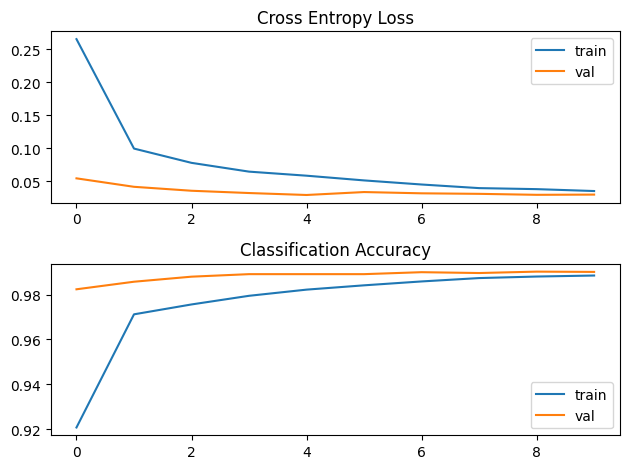

In [57]:
plotTrainingHistory(train_history, val_history)

## Test the model

Load the model that performed the best on the validation data and evaluate it

In [59]:
# Load model
model = ConvolutionalNeuralNetwork().to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

# Test model
test_loss, test_acc = epoch_iter(test_dataloader, model, loss, is_train=False)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

100%|██████████| 2000/2000 [00:05<00:00, 343.91it/s]


Test Loss: 0.038 
Test Accuracy: 0.987


Show examples of results

In [60]:
def showErrors(model, dataloader, num_examples=20):
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

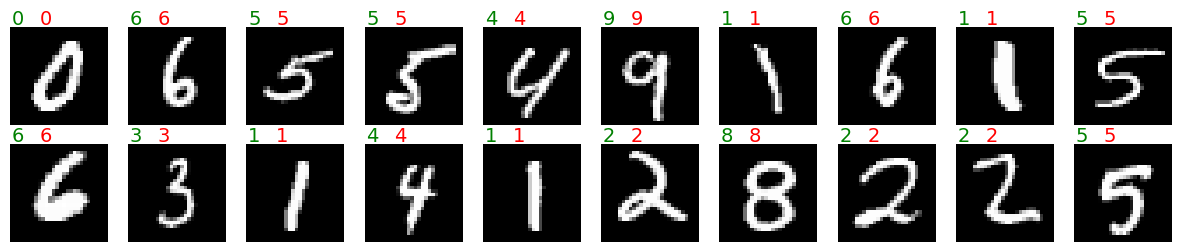

In [61]:
showErrors(model, test_dataloader)

## Additional exercises

a) What is data augmentation and why is it useful? Explore some data augmentation techniques, by using some transforms from [torchvision](https://pytorch.org/vision/stable/transforms.html).

b) Since training a complex model can take a very long time to train, model checkpoints can be saved and loaded later to resume the training. Explore how this can be done: https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

c) Train and test the previous model on the Fashion-MNIST and CIFAR-10 datasets. Some adaptations to the code are necessary for the latter dataset.
